# Lab 1: Ridge and Lasso with CV, GCV, AIC, and BIC

The aim of this lab is to review two examples of penalized regression--namely ridge and lasso. Both of these approaches have a hyperparameter or penalty parameter that needs to be specified. There are many ways to do this, and we will cover some examples, including CV, GCV, AIC, and BIC.

*This lab is adapted from a previous STA 561 lab written by Ed Tam.*

## Review of Ridge and Lasso

Recall from class that the OLS estimator is an unbiased estimator that attains the minimum variance among all unbiased estimators. It may seem that these are good properties to have, which begs the question why we would need to introduce other forms of regression. It turns out penalizing the regression problem can lower overall MSE below at the cost of introducing bias. Two ways we saw in class to do this are ridge regression
$$
\widehat{\mathbf{\beta}}_n^\lambda := \underset{\mathbf{\beta}}{\arg\min}\; \mathbb{P}_n(Y - \mathbf{X}^\intercal\mathbf{\beta})^2 + \lambda\|\mathbf{\beta}\|_2^2
$$
and lasso regression
$$
\widehat{\mathbf{\beta}}_n^\tau := \underset{\mathbf{\beta}}{\arg\min}\; \mathbb{P}_n(Y - \mathbf{X}^\intercal\mathbf{\beta})^2 + \tau\|\mathbf{\beta}\|_1
$$

**Question 1:** Why would you opt to use ridge over lasso? Lasso over ridge?

**Question 2:** (Optional) Are there penalized regression methods that you could use? Why?

### Estimating $\mathbf{\beta}$ with ridge and lasso in sklearn

For today's lab, we will be using the `diabetes` dataset for analysis. Let's start by loading the data and splitting it into train and test sets. Don't forget to scale the design matrix for train and test (why?).

In [1]:
# Load data
import numpy as np
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

y = diabetes.target
X = diabetes.data

# Split data into train and test 75/25
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   random_state=561, 
                                                   test_size=0.25, 
                                                   shuffle=True)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Standardize the design matrix for train and test data
X_train /= np.sqrt(np.sum(X_train**2, axis=0))
X_test /= np.sqrt(np.sum(X_test**2, axis=0))

Using the train data, fit a linear model (without any penalty terms). Predict using the test data and save the results on `y_pred`.

In [2]:
# Load packages
from sklearn.linear_model import LinearRegression

# Fit OLS model here
mod_OLS = LinearRegression()
reg = mod_OLS.fit(X_train, y_train)
y_pred = mod_OLS.predict(X_test)

Using the train data, fit a ridge and lasso regression (using your favorite penalty parameter). Predict the test data and save the results as `y_ridge` `y_lasso`, respectively.

In [3]:
# Load packages
from sklearn.linear_model import Ridge, Lasso
lambda_ = 0.5
tau_ = 0.5

# Fit ridge regression
mod_ridge = Ridge(alpha = lambda_)
mod_ridge.fit(X_train, y_train)
y_ridge = mod_ridge.predict(X_test)

# Fit lasso regression
mod_lasso = Lasso(alpha = tau_)
mod_lasso.fit(X_train, y_train)
y_lasso = mod_lasso.predict(X_test)

### Assessing Model Fit

Next, let's compare how the models perform.

**Question 3:** Compute the MSE and $R^2$ for the test data. Make a table and/or plot for the coefficients comparing them across the models. Describe your findings.

In [4]:
# Code goes here
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

print("MSE OLS: %f" % mean_squared_error(y_test, y_pred))
print("MSE Ridge: %f" % mean_squared_error(y_test, y_ridge))
print("MSE Lasso: %f" % mean_squared_error(y_test, y_lasso))

print("\nR^2 OLS: %f" % r2_score(y_test, y_pred))
print("R^2 Ridge: %f" % r2_score(y_test, y_ridge))
print("R^2 Lasso: %f" % r2_score(y_test, y_lasso))

df = pd.DataFrame({"OLS": mod_OLS.coef_[0],
                   "Ridge" : mod_ridge.coef_[0],
                   "Lasso" : mod_lasso.coef_})
df

MSE OLS: 5391.767615
MSE Ridge: 3648.572252
MSE Lasso: 3918.470693

R^2 OLS: 0.104235
R^2 Ridge: 0.393842
R^2 Lasso: 0.349003


,OLS,Ridge,Lasso
0,5.808709,23.936995,0.000000
1,-195.943462,-107.239822,-0.000000
2,462.396148,345.739056,425.744929
3,291.278208,222.648118,143.590575
4,-783.035700,-14.173923,-0.000000
5,504.562370,-65.462104,-0.000000
6,116.521349,-133.430705,-14.434874
7,54.780689,76.211495,0.000000
8,775.119689,312.753530,384.657233
9,5.120444,68.481357,0.000000


**Question 4:** (Optional Python practice) Write a function that takes a vector of penalty parameters, training data, and test data, and then performs ridge and lasso regression for each penalty parameter. The output should include a vector of MSE values, a vector of $R^2$ values, and an array of coefficients. Assess what penalty parameters work well for each model, and what behavior you observe with the coefficients as the penalty parameter varies. What is one challenging conceptual aspect of this exercise?

## Model Selection

If you did Question 4 (or recall from class), choosing penalty parameters can be tricky. Fortunately, `sklearn` has a lot of built-in tools for tuning these hyperparameters. We'll cover 4: CV, GCV, AIC, and BIC.

### CV and GCV

The idea behind $k$-fold cross-validation (CV) is to partition the data randomly into $k$ groups of data points. We then train on the remaining data, and compute the error on the left out goruop. We then do this across all of the elements in the partition, and average the error. This gives us an idea of the error associated to using a certain value for the penalty parameter $\lambda$. We can compute the the CV error across different values of penalty parameters to choose a regression model.

**Question 5:** How is LOOCV related to CV? Do we randomly partition the data?

Generalized cross-validation (GCV) is an approximation to CV that is motivated by the fact that some problems are rotation-invariant. In both CV and GCV, we want to have low cross-validation error.

### AIC and BIC

The Aikake Information Criterion (AIC) and the Bayesian Information Criterion (BIC) choose a model that fits the data well while penalizing complexity via the number of parameters. More formally,
$$
\text{AIC} := -2\log(\widehat{L}) + 2p
$$
and
$$
\text{BIC} := -2\log(\widehat{L}) + \log(n)\cdot p
$$
where $\widehat{L}$ is the maximum likelihood of the model.

Regression models with smaller AIC/BIC are preferred.

**Question 6:** What can you say about the size of models that AIC will prefer relative to BIC?

### Model Selection with CV, GCV, AIC, and BIC in sklearn

We will continue using the `diabetes` dataset as above. We'll use a method called LARS (least angle regression) for model selection with Lasso. The nice benefit of this is that it automatically computes the lasso path for us.

Start by fitting 10-fold cross-validation on the training data set using Lasso.

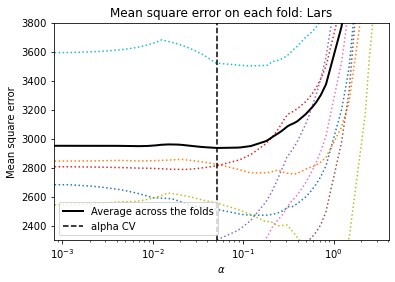

In [5]:
import warnings
warnings.filterwarnings('ignore')

### This code borrows from the following useful sklearn documentation: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py ###

# Load package
from sklearn.linear_model import LassoLarsCV
import matplotlib.pyplot as plt

# Run 10-fold CV
lasso = LassoLarsCV(cv=10).fit(X_train, y_train)

# Show CV path
plt.semilogx(lasso.cv_alphas_, lasso.mse_path_, ":")
plt.semilogx(
    lasso.cv_alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha CV")

ymin, ymax = 2300, 3800
plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(f"Mean square error on each fold: Lars")

Next, let's use AIC and BIC to choose $\tau$:

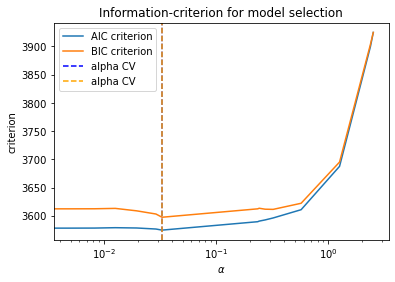

In [6]:
### This code borrows from the following useful sklearn documentation: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py ###


#Load package
from sklearn.linear_model import LassoLarsIC
import pandas as pd

# Fit the model using the AIC criterion
lasso_lars_aic = LassoLarsIC(criterion="aic")
lasso_lars_aic.fit(X_train, y_train)
alpha_aic = lasso_lars_aic.alpha_

# Fit the model using the BIC criterion
lasso_lars_bic = LassoLarsIC(criterion="bic")
lasso_lars_bic.fit(X_train, y_train)
alpha_bic = lasso_lars_bic.alpha_

# Store results in a dataframe for plotting
results = pd.DataFrame(
    {
        "alphas": lasso_lars_aic.alphas_,
        "AIC criterion": lasso_lars_aic.criterion_,
    }
).set_index("alphas")
results["BIC criterion"] = lasso_lars_bic.criterion_

# Plot output
ax = results.plot()
ax.axvline(alpha_aic, linestyle="--", color="blue", label="alpha CV")
ax.axvline(alpha_bic, linestyle="--", color="orange", label="alpha CV")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection"
)

**Question 7:** How do the values of $\tau$ compare across the different criteria?

### What about CV with Ridge?

Good news! If you run LOOCV with ridge regression `sklearn`, it automatically runs GCV. Try it now.

In [7]:
# Load package
from sklearn.linear_model import RidgeCV

# Fit ridge regression using LOOCV
alphas = np.logspace(-2, -0.1, 30)
ridge_cv = RidgeCV(alphas = alphas, store_cv_values = True).fit(X,y)

**Question 8:** Now make a plot of the MSE (use `ridge_cv.cv_values_` to access these) across some folds. Plot alongside it the average across all of the folds.

(0.008035261221856169,
 0.9885530946569389,
 -813.8139379069928,
 17090.09335869354)

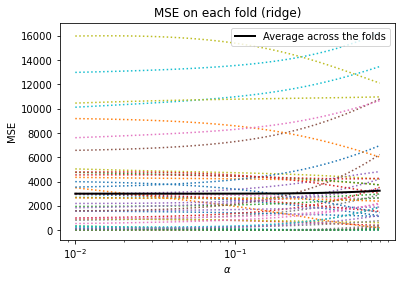

In [8]:
# Make plot of averaged LOOCV error over folds
plt.figure()
for k in range(0, ridge_cv.cv_values_.shape[0], 10):
    plt.semilogx(alphas, ridge_cv.cv_values_[k,:], ':')
plt.semilogx(alphas, ridge_cv.cv_values_.mean(axis=-0), 'k',
            label = 'Average across the folds', linewidth = 2)
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title('MSE on each fold (ridge)')
plt.axis('tight')

### Optional Extension: Elastic Net

Recall Question 2. A very simple extension to the ideas covered here is a penalization method that penalizes using *both*  an $\ell_2$ and an $\ell_1$ term. This can be helpful to leverage the advantages of both regularization methods (reducing collinearity and inducing sparsity). The regression problem is given by
$$
\widehat{\mathbf{\beta}}_n^{\lambda,\tau} := \underset{\mathbf{\beta}}{\arg\min}\; \mathbb{P}_n(Y - \mathbf{X}^\intercal\mathbf{\beta})^2 + \lambda\|\mathbf{\beta}\|_2^2 + \tau\|\mathbf{\beta}\|_1
$$

Note that $\lambda$ and $\tau$ here are not necessarily the same parameters as when you would tune ridge or lasso separately. In fact, in `sklearn`, you only pass one parameter: `l1_ratio`, which is a number between 0 and 1 that corresponds to the ratio of the penalty parameters in elastic net. A value of 1 reduces to Lasso regression.

In [10]:
### This section borrows on some ideas from this documentation: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html#sphx-glr-auto-examples-linear-model-plot-lasso-and-elasticnet-py ###
from sklearn.linear_model import ElasticNet

enet = ElasticNet(l1_ratio=0.7)
enet.fit(X_train, y_train)

ElasticNet(l1_ratio=0.7)

**Question 9:** Using the output of `enet`, find the MSE, $R^2$, and the values of the coefficients. Then compare the results to ridge and lasso.